In [1]:
# Базовые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle as pkl
import warnings
# Метрики
from sklearn.metrics import median_absolute_error, mean_absolute_error
# Модели авторегрессии
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Трансформеры
from scipy.special import boxcox, inv_boxcox
from sklearn.decomposition import PCA
# Регрессия
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Константы:
# доли плотности распределения соответствующая сигма, 2*сигма, 3*сигма
SIGMA_1_FRAC, SIGMA_2_FRAC, SIGMA_3_FRAC= 0.3415, 0.477, 0.4985
# список случайных состояний для MLP
MY_RANDOM_STATES = [31, 423, 519, 575, 586]

# Пути к файлам
# входные данные
path2input_data = 'input//Задание для кандидата_upd.xlsx'
# выходные данные
path2output_data = 'output//Задание для кандидата_upd.xlsx'
# пути для сохранений промежуточных результатов
path2save_trend_cat = 'process//trends4catigories.pkl'
path2save_bc_lmbda = 'process//bc_optim_lmbda.pkl'
path2save_sisons_cat = 'process//sisons4catigories.pkl'

# Отключение предупреждений
warnings.filterwarnings('ignore')

## Считывание исходных данных

In [3]:
df = pd.read_excel(path2input_data, sheet_name=1, index_col=0).sort_values('F_SALE_DT')
df = df.set_index('F_SALE_DT').sort_index()
df

,year,month,family,id_product,sales,test_train
F_SALE_DT,,,,,,
2018-01-02,2018,1,family_6,836722,126.190,train
2018-01-02,2018,1,family_7,437510,198.180,train
2018-01-02,2018,1,family_7,198148,189.714,train
2018-01-02,2018,1,family_6,170522,149.262,train
2018-01-02,2018,1,family_6,1925132,131.875,train
...,...,...,...,...,...,...
2021-09-30,2021,9,family_7,1768582,NaN,test
2021-09-30,2021,9,family_7,437510,NaN,test
2021-09-30,2021,9,family_3,21854,NaN,test


## Аналmиз входных данных

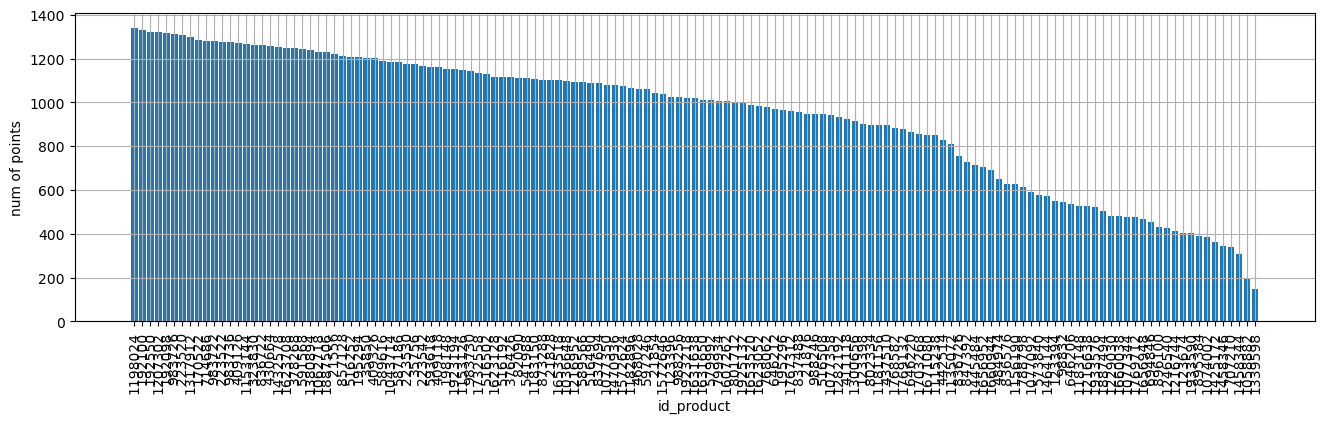

In [4]:
# Взглянем на распределение статистики по товарам
prod_stat = df.id_product.value_counts()
plt.figure(figsize=[16,4])
plt.bar(height= prod_stat.values, x= prod_stat.keys().astype(str))
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('num of points')
plt.xlabel('id_product')
plt.show()

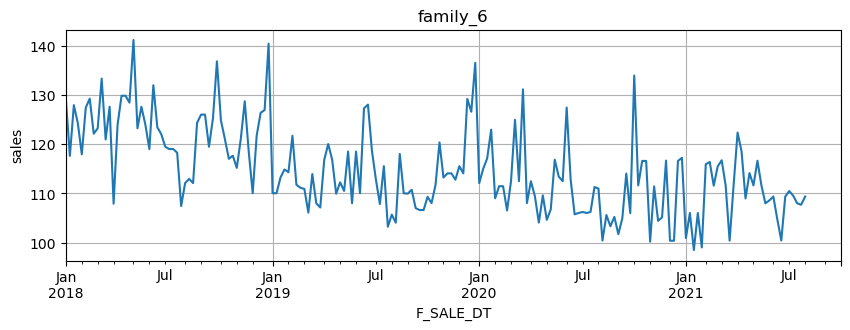

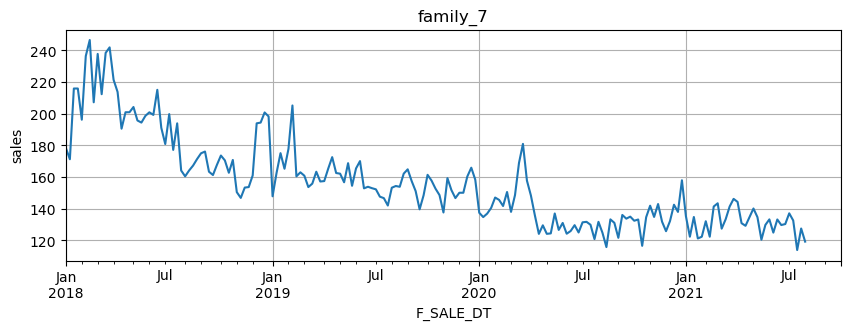

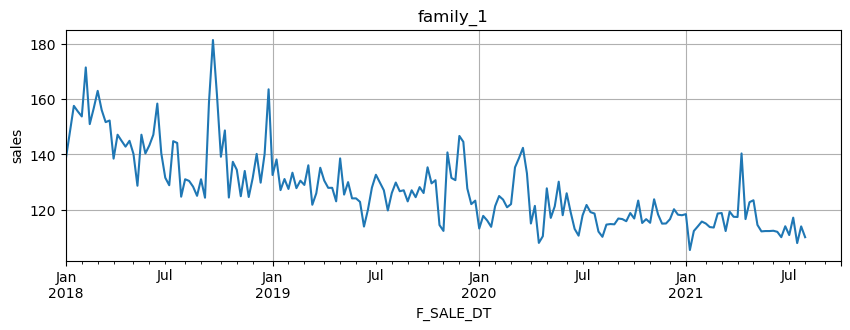

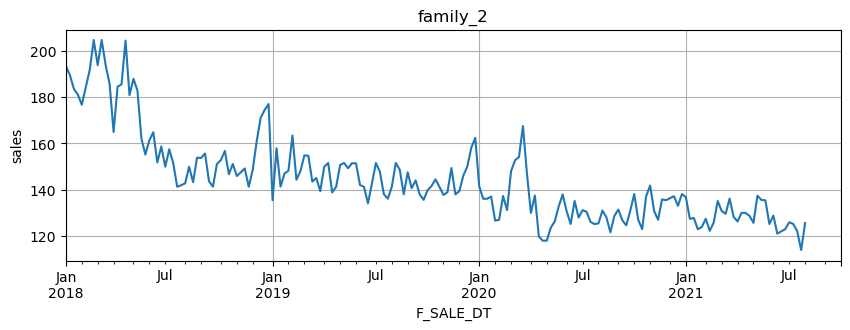

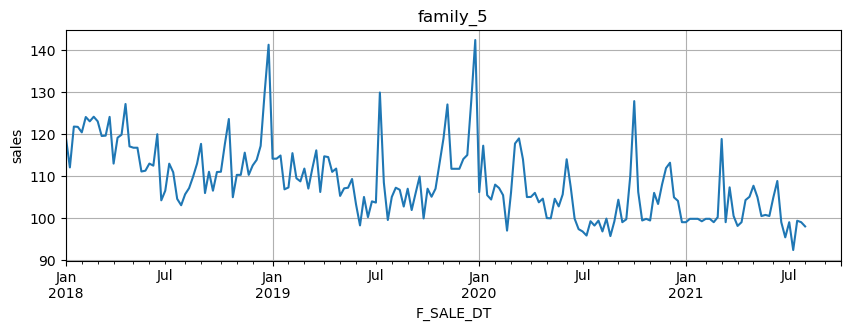

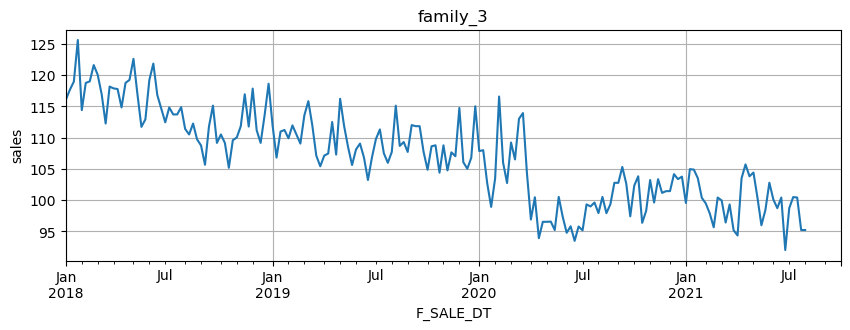

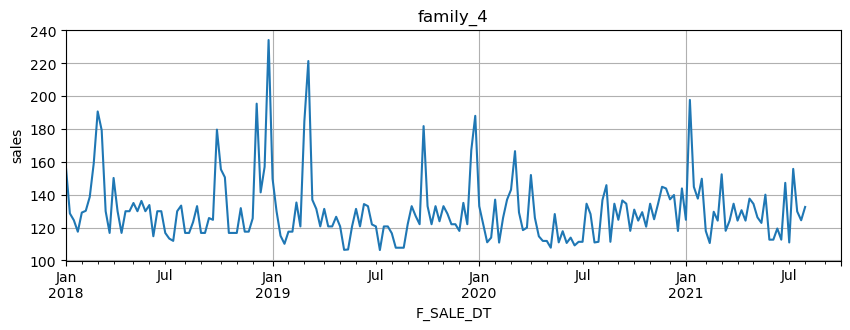

In [5]:
# Посмотрим на продажи по категориям
category_uniq = df.family.unique()
for category in category_uniq:
    ix = category == df.family
    plt.figure(figsize=[10,3])
    df['sales'][ix].resample('W').median().plot()
    plt.title(category)
    plt.ylabel('sales')
    plt.grid()
    plt.plot()

У значений продаж (‘sales’) во входных данных есть два категорийных  свойства (‘family’ и ‘id_product’). Если попытаться построить временной ряд по ‘id_product’, то в общем случае, он получится с множеством пропусков, поскольку продажи по конкретному продукту происходят не регулярно, а эпизодически. Поэтому в качестве основного временного ряда мы рассмотрим ряд по категориям (‘family’).
Оценив вид временные ряды по категориям, можно прийти к выводу, что они имеют сезонность и трену товару


## Методика решения задачи
1)	Построить тренд продаж для каждой категории.
2)	Разделить значение продаж по категориям на их тренды. Тем самым, получить относительные продажи по категориям.
3)	Полученные ряды, избавленные от трендов преобразовать к нормальному распределению. 
4)	Далее построить сезонное предсказание полученных рядов категорий.
5)	Сформируем набор фичей из исходных данных.
6)	Для каждого продукта построим отдельную регрессионную модель.
7)	Построим предсказания относительной стоимости для каждого товара.
8)	Произведем обратные преобразования, чтобы получить цены по каждому товару. 

## Катигории, тренды (шаг= месяц)

In [6]:
date_resampling_param = 'M'
train_valid_frac = 0.8

train_date_start = df.index[~df.sales.isna()].min()

valid_date_finish = df.index[~df.sales.isna()].max()
test_date_start = df.index[df.sales.isna()].min()
test_date_finish = df.index.max()

valid_date_start = train_date_finish = train_date_start+train_valid_frac*(valid_date_finish-train_date_start)

In [7]:
# Произведем поиск модели тренда для кадой категории
model_params = np.array([[12,1], [12,2], [18,1], [18,2], [18,3], [24,1], [24,2], [24,3], [24,4]])
models_rez = np.zeros([category_uniq.shape[0], 7, model_params.shape[0]])
models_qual = np.zeros([category_uniq.shape[0], 2, model_params.shape[0]])
for cat_ix, category in tqdm(enumerate(category_uniq)):
    df_x = df[category==df.family]
    df_x = df_x.iloc[np.argsort(df_x.index.values)]
    df_x_time = df_x[ 'sales'].resample(date_resampling_param).mean()
    df_x_time = df_x_time.interpolate(method='linear')
    train = df_x_time[df_x_time.index <= train_date_finish]
    test = df_x_time[(valid_date_start<=df_x_time.index)&(df_x_time.index<=valid_date_finish)]
    for param_ix, [param_m, param_sp] in enumerate(model_params):
        try:
            model_fitter = pm.auto_arima(train,
                                         start_p= 0, max_p= 3,
                                         start_d= 1, max_d= 3,
                                         start_q= 1, max_q= 3,
                                         start_P= 1, max_P= 3,
                                         D= 1, max_D= 4,
                                         start_Q= 1, max_Q= 4, 
                                         sp = param_sp, seasonal= True, m= param_m,
                                     stepwise= True, suppress_warnings= True, 
                                     error_action= 'ignore',  maxiter= 500, scoring= 'mae', random_state= MY_RANDOM_STATES[0])#, n_jobs= 4)
        
            preds, conf_int = model_fitter.predict(n_periods=test.shape[0], return_conf_int=True)
            
            models_rez[cat_ix, :3, param_ix] = model_fitter.get_params()['order']
            models_rez[cat_ix, 3:, param_ix] = model_fitter.get_params()['seasonal_order']
            models_qual[cat_ix, :, param_ix] = [mean_absolute_error(test, preds), median_absolute_error(test, preds)]
        except ValueError:
            print("Unstable model!")
            models_rez[cat_ix, :, param_ix] = np.nan
            models_qual[cat_ix, :, param_ix] = np.nan

5it [01:37, 19.99s/it]

Unstable model!
Unstable model!
Unstable model!


6it [01:54, 18.94s/it]

Unstable model!


7it [02:08, 18.38s/it]


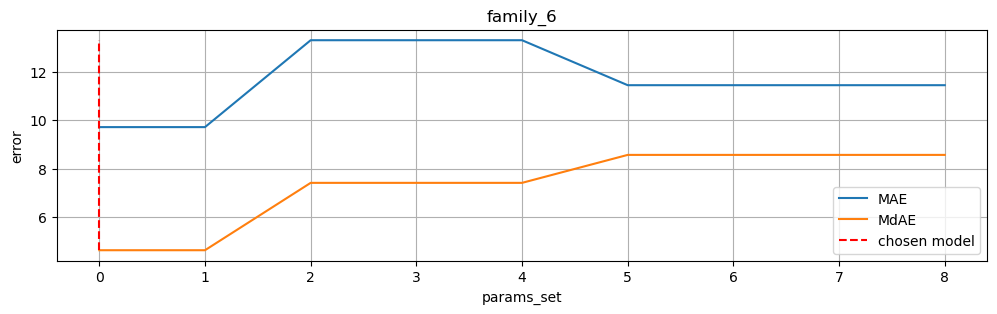

catigory: family_6 , order: [0. 0. 0.] , seasonal order: [ 0.  1.  0. 12.]


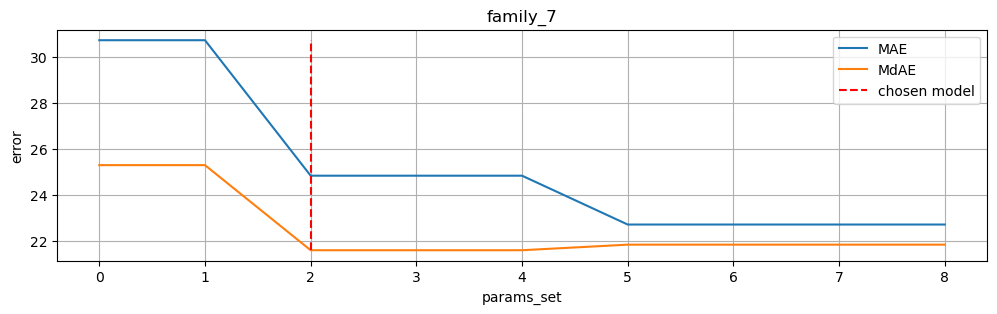

catigory: family_7 , order: [0. 0. 0.] , seasonal order: [ 0.  1.  0. 18.]


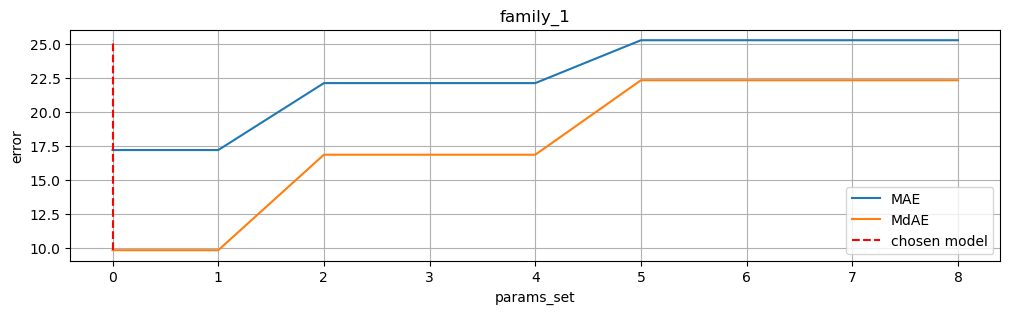

catigory: family_1 , order: [0. 0. 0.] , seasonal order: [ 1.  1.  0. 12.]


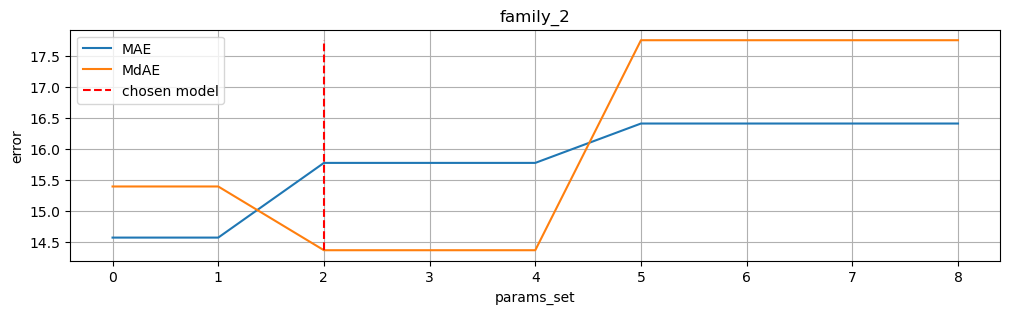

catigory: family_2 , order: [2. 0. 0.] , seasonal order: [ 0.  1.  0. 18.]


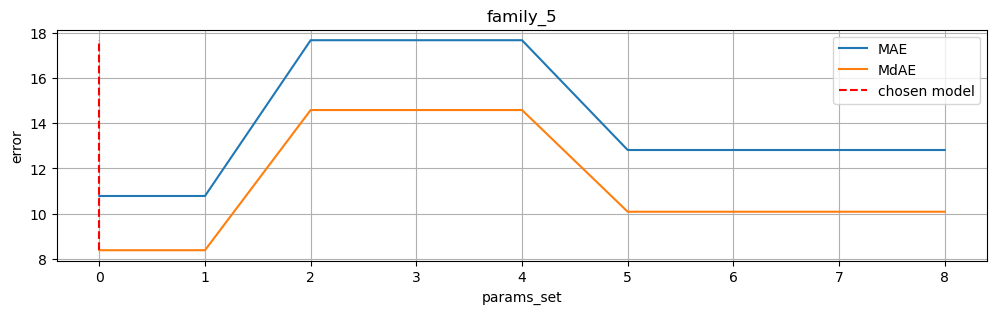

catigory: family_5 , order: [0. 0. 0.] , seasonal order: [ 1.  1.  0. 12.]


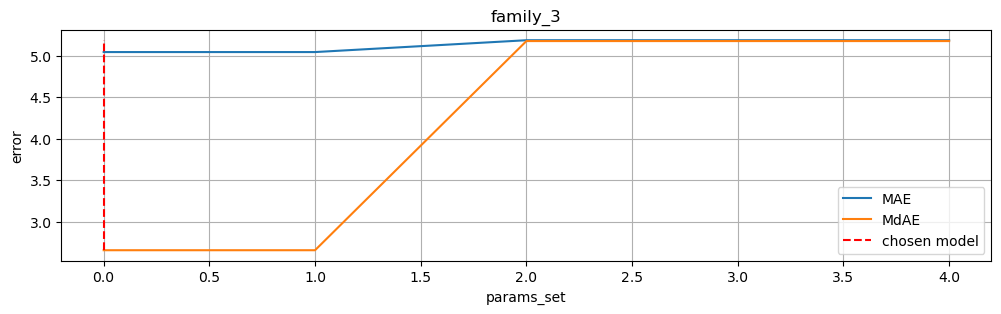

catigory: family_3 , order: [0. 0. 0.] , seasonal order: [ 1.  1.  0. 12.]


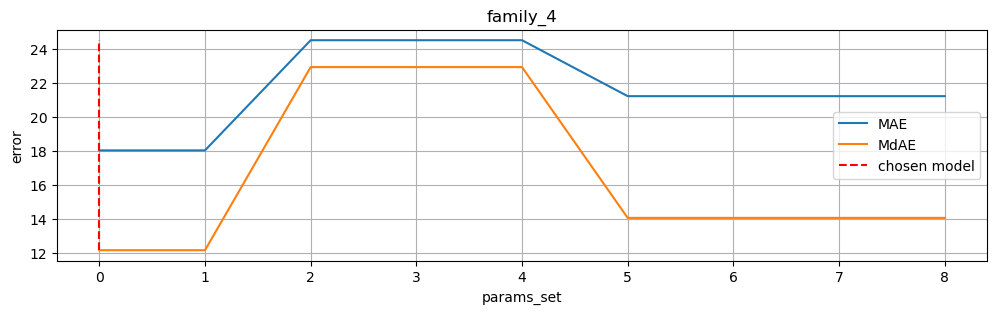

catigory: family_4 , order: [0. 0. 0.] , seasonal order: [ 1.  1.  0. 12.]


In [8]:
# Визуализируем результаты поиска и выберем лучшую модель (критерий min(MdAE))
trend_model_params = np.zeros([category_uniq.shape[0], 7])
for cat_ix in range(category_uniq.shape[0]):
    ix_best_model = np.nanargmin(models_qual[cat_ix,1,:])
    plt.figure(figsize=[12,3])
    plt.plot(models_qual[cat_ix,0,:])
    plt.plot(models_qual[cat_ix,1,:])
    plt.plot([ix_best_model, ix_best_model], [np.nanmin(models_qual[cat_ix,:,:]), np.nanmax(models_qual[cat_ix,:,:])],'r--')
    plt.legend(['MAE', 'MdAE', 'chosen model'])
    plt.grid()
    plt.ylabel('error')
    plt.xlabel('params_set')
    plt.title(category_uniq[cat_ix])
    plt.show()
    trend_model_params[cat_ix,:] = models_rez[cat_ix, : ,ix_best_model]
    print('catigory:', category_uniq[cat_ix], ',', 'order:', models_rez[cat_ix, :3, ix_best_model],
          ',', 'seasonal order:', models_rez[cat_ix, 3:, ix_best_model])

In [9]:
# Построим тренды для категорий на основе лучших моделей.
trends4catigories = []
for cat_ix, category in tqdm(enumerate(category_uniq)):
    df_x = df[category==df.family]
    df_x = df_x.iloc[np.argsort(df_x.index.values)]
    
    df_x_time = df_x[ 'sales'].resample(date_resampling_param).mean()
    df_x_time = df_x_time.interpolate(method='linear')
    train = df_x_time[df_x_time.index <= valid_date_finish]
    model = SARIMAX(train, order= trend_model_params[cat_ix, :3], seasonal_order= trend_model_params[cat_ix, 3:]) 
    trend = pd.concat([train, model.fit().forecast(steps=5)])
    trends4catigories.append(trend)

with open(path2save_trend_cat, 'wb') as f:
    pkl.dump(trends4catigories, f)

7it [00:00, 43.87it/s]


In [10]:
# with open(path2save_trend_cat, 'rb') as f:
#     trends4catigories = pkl.load(f)
trand_of_sales = pd.Series(index=df.index)
detrend_sales = pd.Series(index=df.index)
for cat_ix in range(category_uniq.shape[0]):
    df2 = df[['family', 'sales']].copy()
    trand_m = trends4catigories[cat_ix]
    # trand_d = pd.Series(index=pd.date_range(trand_m.index.min(), trand_m.index.max(), freq="1D"))
    trand_d = ((2*trand_m.resample('D').mean().interpolate(method='linear') + trand_m.resample('D').mean().interpolate(method='quadratic'))/3)
    if df.index.min() < trand_d.index.min():
        buf = pd.Series(index=pd.date_range(df.index.min(), trand_d.index.min() - pd.Timedelta("1 days"), freq="1D"))
        buf.iloc[0] = trand_d.iloc[0]
        trand_d = pd.concat([buf, trand_d]).interpolate(method='quadratic')
    
    df2['trand_cat'] = trand_d
    ix = (df2.family == category_uniq[cat_ix]).values
    trand_of_sales.loc[ix] = df2.trand_cat.loc[ix]
    detrend_sales.loc[ix] = df2.sales.loc[ix]/df2.trand_cat.loc[ix]

## Трансформация относительных катигорийных продаж к нормальному распределению
## (по sigma)

In [11]:
def optim_box_cox(x, min_lmbda= -3, max_lmbda= 0, stp_lmbda= 0.001):
    x2 = x[~np.isnan(x)]
    min_loss = 1e18
    best_lmbda = 0
    for lmbda in np.arange(min_lmbda, max_lmbda, stp_lmbda):
        y = boxcox(x2, lmbda)
        q_subs_1sigma = np.nanquantile(y, 0.5 - SIGMA_1_FRAC)
        q_plus_1sigma = np.nanquantile(y, 0.5 + SIGMA_1_FRAC)
        q_subs_2sigma = np.nanquantile(y, 0.5 - SIGMA_2_FRAC)
        q_plus_2sigma = np.nanquantile(y, 0.5 + SIGMA_2_FRAC)
        q_subs_3sigma = np.nanquantile(y, 0.5 - SIGMA_3_FRAC)
        q_plus_3sigma = np.nanquantile(y, 0.5 + SIGMA_3_FRAC)
        y_mean = np.nanmean(y)
        y_median = np.nanmedian(y) 
        y_std = np.nanstd(y)
        loss = (np.abs(y_mean - y_median) +
                np.abs(q_subs_1sigma - (y_mean - y_std)) + 
                np.abs(q_plus_1sigma - (y_mean + y_std)) +
                np.abs(q_subs_2sigma - (y_mean - 2*y_std)) + 
                np.abs(q_plus_2sigma - (y_mean + 2*y_std)) +
                np.abs(q_subs_3sigma - (y_mean - 3*y_std)) + 
                np.abs(q_plus_3sigma - (y_mean + 3*y_std))
               )/(np.nanquantile(y, 0.98) - np.nanquantile(y, 0.2))
        if loss < min_loss:
            min_loss = loss
            best_lmbda = lmbda
    rez = np.full(x.shape[0], np.nan)
    rez[~np.isnan(x)] = boxcox(x2, best_lmbda)
    return rez, best_lmbda

In [12]:
detrand_bc_sales = pd.Series(index=df.index)
bc_optim_lmbda = np.zeros(category_uniq.shape[0])
for cat_ix in range(category_uniq.shape[0]):
    ix = (df.family == category_uniq[cat_ix]).values
    _, lmbda = optim_box_cox(detrend_sales[ix].resample('D').mean().values)
    bc_optim_lmbda[cat_ix] = lmbda
    detrand_bc_sales.loc[ix] = boxcox(detrend_sales[ix], lmbda)
with open(path2save_bc_lmbda, 'wb') as f:
    pkl.dump(bc_optim_lmbda, f)

## Категории, сезоны (детренд) (шаг= неделя)

In [13]:
train_valid_frac = 0.85
ate_resampling_param = 'W'

train_date_start = df.index[~df.sales.isna()].min()
valid_date_finish = df.index[~df.sales.isna()].max()
test_date_start = df.index[df.sales.isna()].min()
test_date_finish = df.index.max()
valid_date_start = train_date_finish = train_date_start+train_valid_frac*(valid_date_finish-train_date_start)

train_half_date_shart = (train_date_finish - train_date_start)/2 + train_date_start

In [14]:
# Поиск оптимальных моделей для формирования сезонного ряда относительных стоимостей по категориям
model_params = np.array([[4,1], [13,1], [13,2]])
models_rez = np.zeros([category_uniq.shape[0], 7, model_params.shape[0]])
models_qual = np.zeros([category_uniq.shape[0], 2, model_params.shape[0]])
for cat_ix, category in tqdm(enumerate(category_uniq)):
    df_x_time = detrand_bc_sales[category==df.family].resample(date_resampling_param).mean()
    df_x_time = df_x_time.interpolate(method='linear')
    train = df_x_time[(train_half_date_shart<=df_x_time.index)&(df_x_time.index <= train_date_finish)]
    test = df_x_time[(valid_date_start<=df_x_time.index)&(df_x_time.index<=valid_date_finish)]
    for param_ix, [param_m, param_sp] in enumerate(model_params):    
        try:
            model_fitter = pm.auto_arima(train,
                                         start_p= 0, max_p= 3,
                                         start_d= 1, max_d= 3,
                                         start_q= 1, max_q= 3,
                                         start_P= 1, max_P= 3,
                                         D= 1, max_D= 4,
                                         start_Q= 1, max_Q= 4, 
                                         sp = param_sp, seasonal= True, m= param_m,
                                     stepwise= True, suppress_warnings= True, 
                                     error_action= 'ignore',  maxiter= 500, scoring= 'mae', random_state= MY_RANDOM_STATES[0])#, n_jobs= 4)
        
            preds, conf_int = model_fitter.predict(n_periods=test.shape[0], return_conf_int=True)
            models_rez[cat_ix, :3, param_ix] = model_fitter.get_params()['order']
            models_rez[cat_ix, 3:, param_ix] = model_fitter.get_params()['seasonal_order']
            models_qual[cat_ix, :, param_ix] = [mean_absolute_error(test, preds), median_absolute_error(test, preds)]
        except ValueError:
            print("Unstable model!")
            models_rez[cat_ix, :, param_ix] = np.nan
            models_qual[cat_ix, :, param_ix] = np.nan

7it [00:14,  2.10s/it]


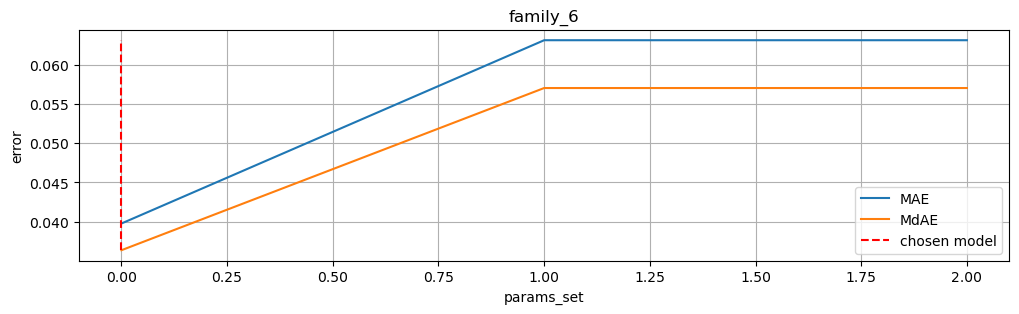

catigory: family_6 , order: [0. 0. 0.] , seasonal order: [0. 1. 1. 4.]


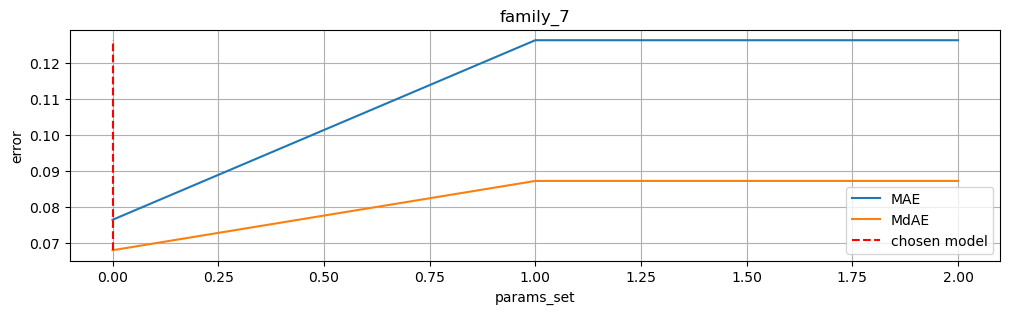

catigory: family_7 , order: [0. 0. 0.] , seasonal order: [0. 1. 0. 4.]


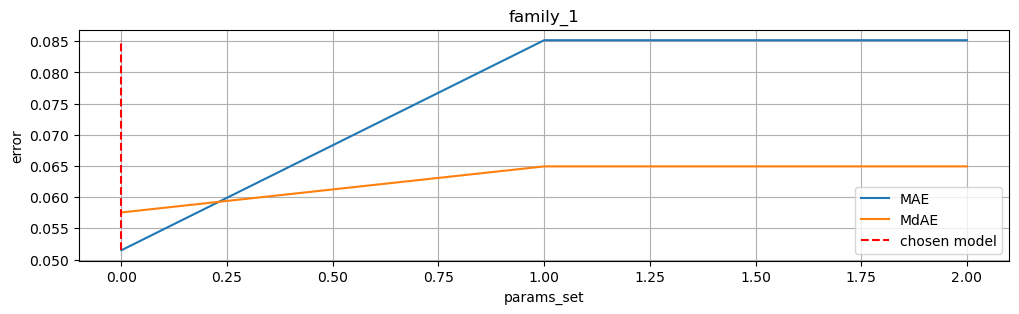

catigory: family_1 , order: [0. 0. 1.] , seasonal order: [0. 1. 0. 4.]


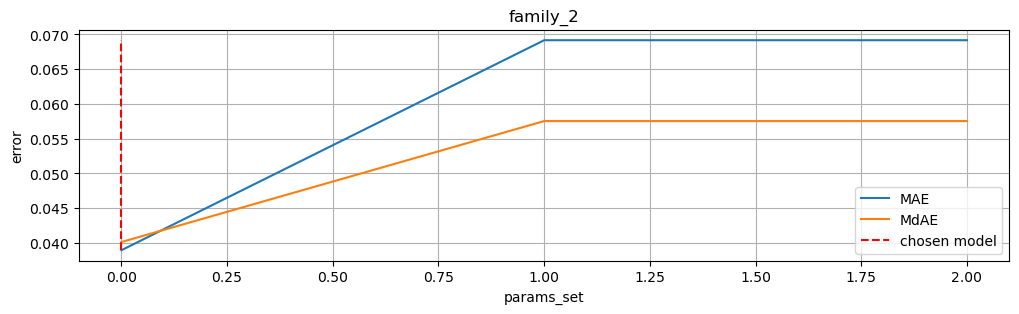

catigory: family_2 , order: [0. 0. 0.] , seasonal order: [1. 1. 0. 4.]


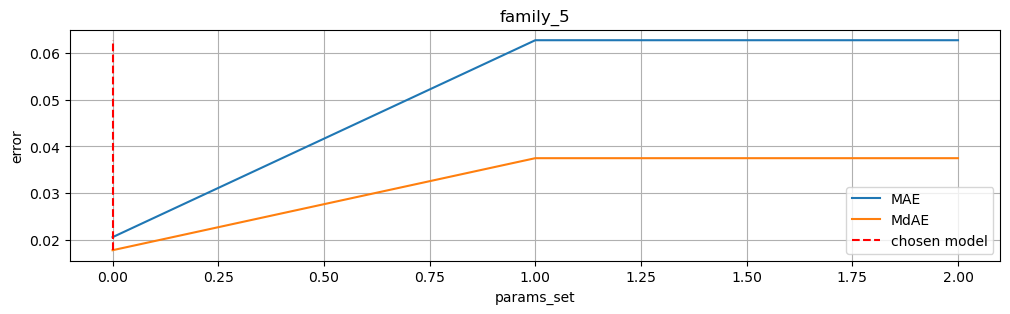

catigory: family_5 , order: [0. 0. 1.] , seasonal order: [3. 1. 0. 4.]


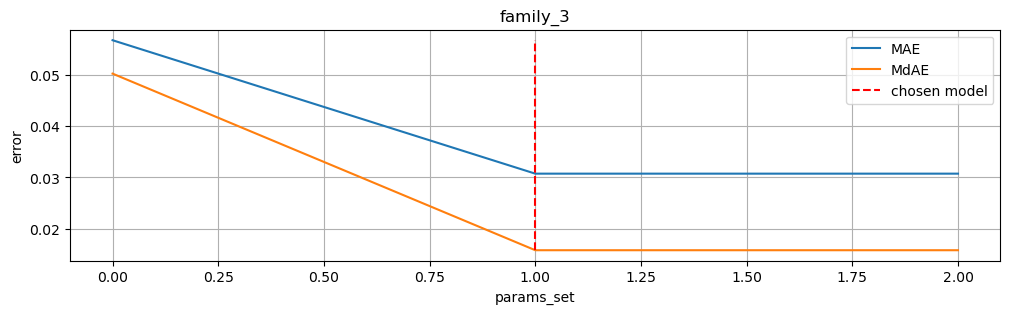

catigory: family_3 , order: [0. 0. 0.] , seasonal order: [ 0.  1.  0. 13.]


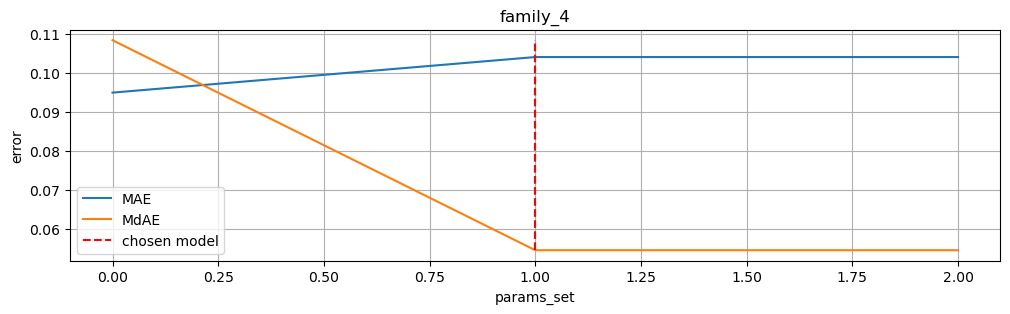

catigory: family_4 , order: [0. 0. 0.] , seasonal order: [ 0.  1.  0. 13.]


In [15]:
# Анализ результатов моделей и выбор оптимальной.
second_model_params = np.zeros([category_uniq.shape[0], 7])
for cat_ix in range(category_uniq.shape[0]):
    ix_best_model = np.nanargmin(models_qual[cat_ix,1,:])
    plt.figure(figsize=[12,3])
    plt.plot(models_qual[cat_ix,0,:])
    plt.plot(models_qual[cat_ix,1,:])
    plt.plot([ix_best_model, ix_best_model], [np.nanmin(models_qual[cat_ix,:,:]), np.nanmax(models_qual[cat_ix,:,:])],'r--')
    plt.legend(['MAE', 'MdAE', 'chosen model'])
    plt.grid()
    plt.ylabel('error')
    plt.xlabel('params_set')
    plt.title(category_uniq[cat_ix])
    plt.show()
    second_model_params[cat_ix,:] = models_rez[cat_ix, : ,ix_best_model]
    print('catigory:', category_uniq[cat_ix], ',', 'order:', models_rez[cat_ix, :3, ix_best_model],
          ',', 'seasonal order:', models_rez[cat_ix, 3:, ix_best_model])

In [16]:
# Применение лучших моделей для формирования относительного сезонного ряда по категориям
sisons4catigories = []
for cat_ix, category in tqdm(enumerate(category_uniq)):
    df_x_time = detrand_bc_sales[category==df.family].resample(date_resampling_param).mean()
    df_x_time = df_x_time.interpolate(method='linear')
    train = df_x_time[df_x_time.index <= valid_date_finish]
    model = SARIMAX(train, order= second_model_params[cat_ix, :3], seasonal_order= second_model_params[cat_ix, 3:]) 
    trend = pd.concat([train, model.fit().forecast(steps=5)])
    sisons4catigories.append(trend)
with open(path2save_sisons_cat, 'wb') as f:
    pkl.dump(sisons4catigories, f)

7it [00:00, 40.79it/s]


In [17]:
# Построение итогового относительного сезонного ряда по категориям
detrend_bc_sales_2 = pd.Series(index=df.index)
for cat_ix in range(category_uniq.shape[0]):
    df2 = df[['family', 'sales']].copy()
    trand_w = sisons4catigories[cat_ix]
    trand_d = ((2*trand_w.resample('D').mean().interpolate(method='linear') + trand_w.resample('D').mean().interpolate(method='quadratic'))/3)
    if df.index.min() < trand_d.index.min():
        buf = pd.Series(index=pd.date_range(df.index.min(), trand_d.index.min() - pd.Timedelta("1 days"), freq="1D"))
        buf.iloc[0] = trand_d.iloc[0]
        trand_d = pd.concat([buf, trand_d]).interpolate(method='quadratic')
    df2['detrend_bc_sales_2'] = trand_d
    ix = (df2.family == category_uniq[cat_ix]).values
    detrend_bc_sales_2.loc[ix]= df2['detrend_bc_sales_2'][ix]

## Формирование фичей

In [18]:
def make_feature(dat, sales, categories, target_category= 0):
    rez = np.full(dat.shape, np.nan)
    for val in np.unique(dat):
        ix1 = np.where((dat == val)&(categories == target_category))[0]
        ix2 = np.where(dat == val)[0]
        rez[ix2] = np.nanmean(sales[ix1])
    return rez

sales = detrend_bc_sales_2.values
categories = df.family.values

# День в году
df['day_of_Y'] = (df.index - pd.to_datetime(df.index.year.astype(str).to_numpy() + '-01-01')).days.to_numpy() + 1
# День в месяце
df['day_of_M'] = pd.to_datetime(df.index).day.values
# День в неделе
df['day_of_W'] = (df.index.values.astype('datetime64[D]').view('int64') - 4) % 7
# Квартал года
df['quart_of_Y'] = (pd.to_datetime(df.index).month.values-1)%4

# Средлнее значение продаж для дня недели
df['sales_f1'] = make_feature(df['day_of_W'].values, sales, np.zeros(sales.shape[0]).astype(int))

# # Средлнее значение продаж для дня в месяце
df['sales_f2'] = make_feature(df['day_of_M'].values, sales, np.zeros(sales.shape[0]).astype(int))

# # Средлнее значение продаж для месяца
df['sales_f3'] = make_feature(df['month'].values, sales, np.zeros(sales.shape[0]).astype(int))

# Средлнее значение продаж для квартала года
df['sales_f4'] = make_feature(df['quart_of_Y'].values, sales, np.zeros(sales.shape[0]).astype(int))

# Средлнее значение продаж в году
df['sales_f5'] = make_feature(df['year'].values, sales, np.zeros(sales.shape[0]).astype(int), np.zeros(sales.shape[0]).astype(int))

# Средлнее значение продаж для дня недели по карегориям
buf = df['day_of_W'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+i)] = make_feature(buf, sales, categories, cat_name).copy()

# Средлнее значение продаж для дня в месяце по карегориям
buf = df['day_of_M'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+2*len(category_uniq)+i)] = make_feature(buf, sales, categories, cat_name).copy()

# Средлнее значение продаж для дня недели по карегориям
buf = df['day_of_Y'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+3*len(category_uniq)+i)] = make_feature(buf, sales, categories, cat_name).copy()

# # Средлнее значение продаж для месяца по карегориям
buf = df['month'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+4*len(category_uniq)+i)] = make_feature(buf, sales, categories, cat_name).copy()

# Средлнее значение продаж для квартала года по карегориям
buf = df['quart_of_Y'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+5*len(category_uniq)+i)] = make_feature(buf, sales, categories, cat_name).copy()

# Средлнее значение продаж в году по карегориям
buf = df['year'].values
for i, cat_name in enumerate(category_uniq):
    df['sales_f' + str(6+6*len(category_uniq)+i)] = make_feature(buf, sales, categories, cat_name).copy()

# Сформируем итоговый набор фичей
x = df.drop(columns=['family', 'id_product', 'sales', 'test_train']).astype(float).values

Отнормируем массив фичей по мат.ожиданию и дисперсии

In [19]:
def norm_mx(dat_mx, scale_param=None):
    def norm(dat, m= None, d=None):
        if m is None:
            m = np.nanmean(dat)
        if d is None:
            d = np.power(np.nanstd(dat), 0.5)
        return (dat - m)/d, [m, d]

    rez = np.zeros_like(dat_mx)
    if scale_param is None:
        scale_param_culc = []
    for i in range(dat_mx.shape[1]):
        if scale_param is None:
            rez[:, i], buf = norm(dat_mx[:, i])
            scale_param_culc.append(buf)
        else:
            rez[:, i], buf = norm(dat_mx[:, i], scale_param[i, 0], scale_param[i, 1])
    if scale_param is None:
        return rez, np.array(scale_param_culc)
    return rez, scale_param

x_norm, x_scale_param = norm_mx(x)

Избавимся от возможной линейной зависимости среди фичей, а заодно и понизим размерность применив МГК.

In [20]:
def pca_optimal(x, brd_val= 0.98):
    rez = []
    for n_comp in range(2,x.shape[1]-1):
        pca = PCA(n_components=n_comp)
        pca.fit(x)
        if pca.explained_variance_ratio_.sum() > brd_val:
            return pca.transform(x), pca
    return x_train_norm2, []

x_pca, x_pca_optim = pca_optimal(x_norm, 0.999)
print('Размерность массива фичей:\n\tдо сжатия:',x_norm.shape[1], ',', 'после:', x_pca.shape[1])

Размерность массива фичей:
	до сжатия: 53 , после: 9


## Поиск зависимостей для относительных стоимостей продуктов

In [21]:
prod_uniq = df.id_product.unique()
# Параметы для перебора
param_grid = {'random_state': MY_RANDOM_STATES, 'max_iter': np.arange(25, 56, 5), 'solver':['adam', 'lbfgs'], 'learning_rate' : ['constant']}
detrend_bc_sales_2_forecast = detrend_bc_sales_2.copy()
for prod_id in tqdm(prod_uniq):
    ix_train = np.where((prod_id == df.id_product.values)&(df.index<=valid_date_finish))[0]
    ix_forecast = np.where((prod_id == df.id_product.values)&(valid_date_finish<df.index))[0]
    grid = GridSearchCV(
        MLPRegressor(), param_grid, scoring= 'neg_median_absolute_error', refit = True,
        verbose = 0, n_jobs=-1).fit(x_pca[ix_train], detrend_bc_sales_2.values[ix_train]) 
    # Использование лучшей модели для восстановления относительной цены по продукту
    detrend_bc_sales_2_forecast.iloc[ix_forecast] = grid.predict(x_pca[ix_forecast])

100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [02:40<00:00,  1.14s/it]


## Обратные преобразования с целью восстановления исходных стоимостей продуктов

In [22]:
# Формирования относительнх сатегорийный трендов
detrend_sales_forecast = pd.Series(index= detrend_bc_sales_2_forecast.index)
for i, category in tqdm(enumerate(category_uniq)):
    ix = category == df.family
    detrend_sales_forecast.loc[ix] = inv_boxcox(detrend_bc_sales_2_forecast[ix].values, bc_optim_lmbda[i])
# Восстановление значений цен
sales_forecast = detrend_sales_forecast*trand_of_sales

7it [00:00, 225.02it/s]


Визуализируем результат работы. Построим графики со сравнением исходных и расчитанных стоимостей по категориям (с шагом в 1 неделю).

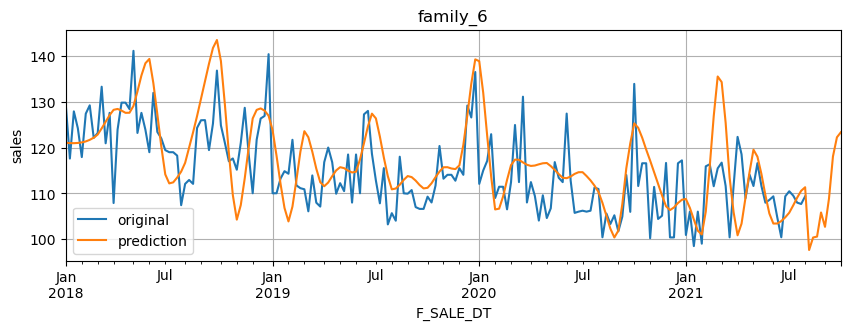

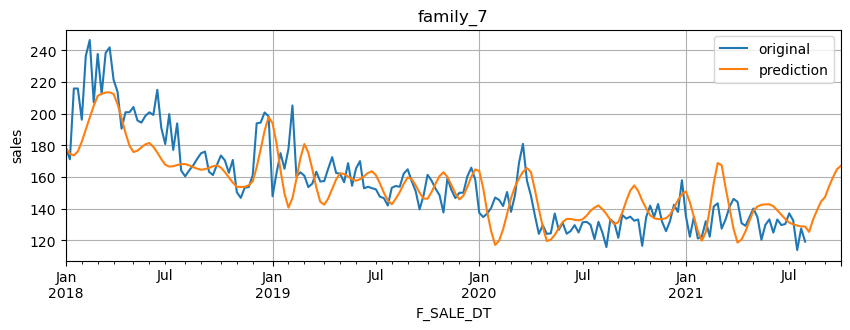

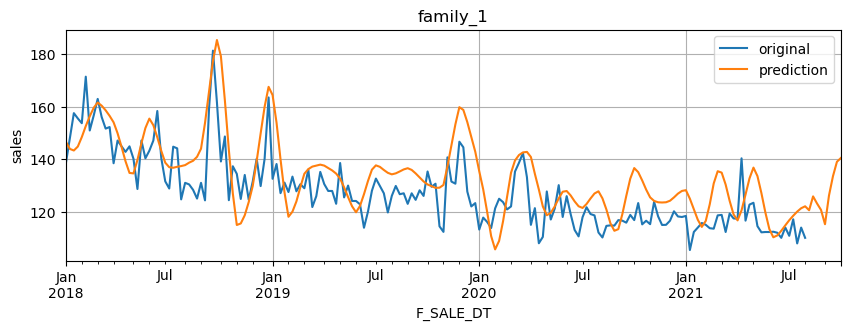

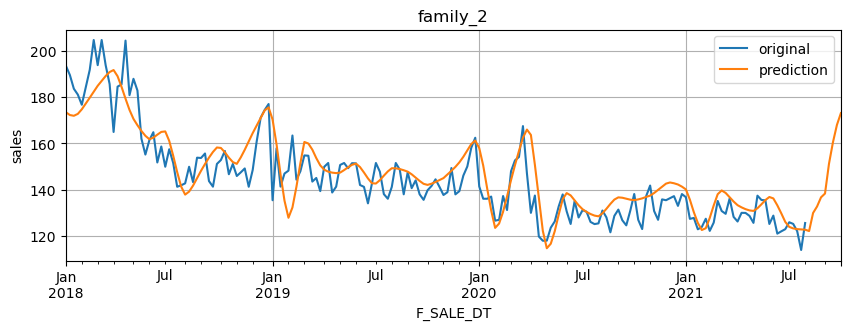

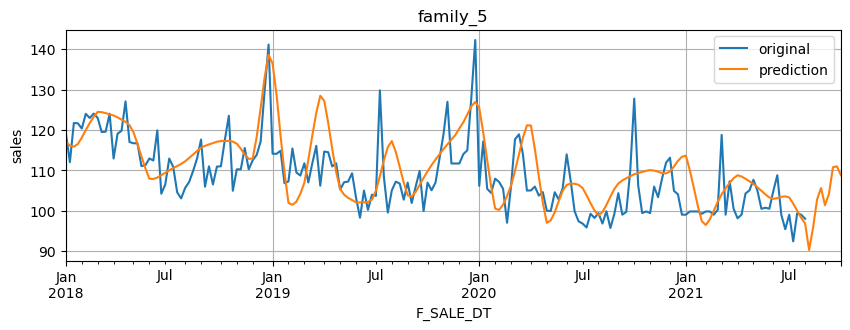

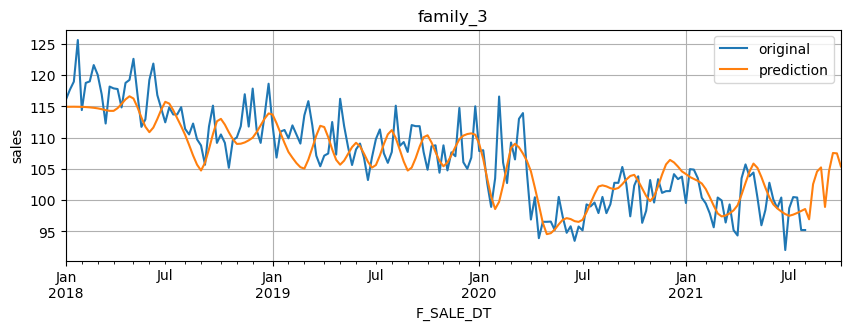

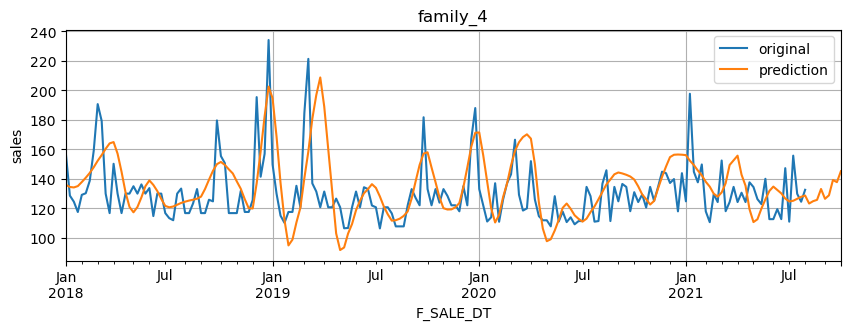

In [23]:
for category in category_uniq:
    ix = category == df.family
    plt.figure(figsize=[10,3])
    df['sales'][ix].resample('W').median().plot()
    sales_forecast[ix].resample('W').median().plot()
    plt.title(category)
    plt.ylabel('sales')
    plt.legend(['original', 'prediction'])
    plt.grid()
    plt.plot()

Как можно видеть получившиеся оценка хорошо повторяют исходный ряды. Однако, ближе к зоне прогнозирования, ряд категории 'family_1' немного завышает значения.

Внесем небольшую правку простым сдвигом значений вблизи зоны прогнозирования.

5.442145245791252


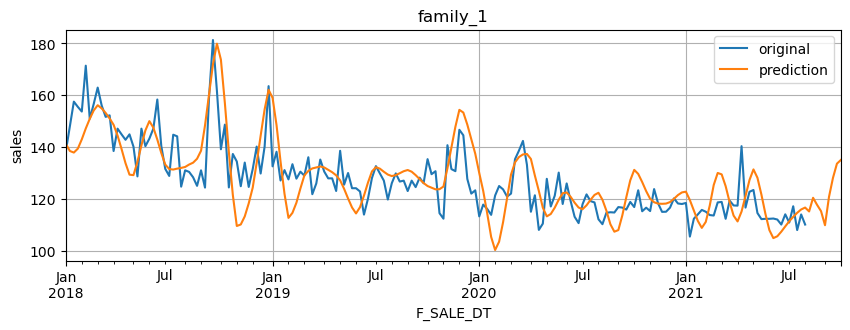

In [24]:
for category in ['family_1']:
    ix = (category == df.family)
    buf = sales_forecast[ix].resample('D').median().interpolate()
    ix2 = (valid_date_start<buf.index)&(buf.index<valid_date_finish)
    delta = buf[ix2].median() - df['sales'][ix].resample('D').median()[ix2].dropna().median()
    sales_forecast.loc[ix] = sales_forecast[ix] - delta
    plt.figure(figsize=[10,3])
    df['sales'][ix].resample('W').median().plot()
    sales_forecast[ix].resample('W').median().plot()
    plt.title(category)
    plt.ylabel('sales')
    plt.legend(['original', 'prediction'])
    plt.grid()
    plt.plot()
    print(delta)

## Заполнение проверочной таблицы

In [25]:
# Считывание проверочной таблицы
path2input_data = 'input//Задание для кандидата_upd.xlsx'
df_exam = pd.read_excel(path2input_data, sheet_name=2, index_col=0)

# Заполнение таблицы
prod_uniq_exam = df_exam.id_product.unique()
month_uniq_exam = df_exam.month.unique()
for prod_id in prod_uniq_exam:
    for month in month_uniq_exam:
        ix_exam = (prod_id == df_exam.id_product)&(month == df_exam.month)
        ix_base = (prod_id == df.id_product)&(month == df.month)
        df_exam.iloc[ix_exam,3] = sales_forecast[ix_base].median()
display(df_exam)

# Сохранение результатов
writer = pd.ExcelWriter(path2output_data, engine = 'xlsxwriter')
for sheet in pd.ExcelFile(path2input_data).sheet_names:
    buf = pd.read_excel(path2input_data, sheet_name= sheet, index_col=0)
    if sheet == 'result':
        df_exam.to_excel(writer, sheet_name= sheet)
    else:
        buf.to_excel(writer, sheet_name= sheet)
writer.close()

,month,family,id_product,sales
year,,,,
2021,8,family_1,21556,128.705292
2021,8,family_1,21876,129.418984
2021,8,family_1,98832,130.994360
2021,8,family_1,195294,129.183937
2021,8,family_1,195296,130.111223
...,...,...,...,...
2021,9,family_7,1703268,158.248824
2021,9,family_7,1768582,153.406719
2021,9,family_7,1769712,159.819243
